In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [40]:
# 데이터를 불러오면서 리뷰 열만 가져오기
data = pd.read_csv('./data/data_te.csv', encoding='ANSI')
data1 = data.REVIEW

In [41]:
a = input('리뷰를 입력하세요: ')
print(a)

오랜만에 생각나서 복귀했는데 이벤트도 많이 하고 퍼주는 덕분에 소과금 하면서 잘 하고 있어요~!! 일러 예뻐서 눈이 즐겁네요😍😍


In [42]:
len(data1)

54080

In [43]:
# 필요없는데 label에서의 긍/부정 비율만 확인하고자 넣은 것...
data['label'] = np.select([data.star > 3], [1], default=0)
data.head()

,DATE,REVIEW,star,label
0,2021-03-10,몇달만에 접속했는데. 서버도 다 통합 되어있고 내가 키우던 캐릭이 하나도 없이. 나...,3,0
1,2020-03-16,오랜만에 복귀하려고 설치해봤습니다. 하지만 처음 서버 선택 후 캐릭터선택창에 진입시...,1,0
2,2021-03-01,불편한 점 하나 얘기하자면 음악 들으면서 게임하고플 때 소리 다 줄이려면 일일이 볼...,4,1
3,2021-03-08,게임 처음 설치 후 다운로드가 현재 8시간 동안 진행중인데도 불구하고 아직 1.2G...,3,0
4,2021-03-03,점검하고 나서 들어갔는데 계정이 다 날아갔어요 어떻게 된거죠? 최대한 빨리 복구해주...,3,0


<AxesSubplot:>

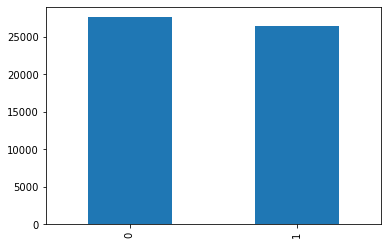

In [44]:
data['label'].value_counts().plot(kind = 'bar')

In [45]:
print(data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  27605
1      1  26475


In [46]:
# 맨 마지막 행에 입력한 리뷰를 넣기
data1.loc[len(data1)] = a
data1.tail()

54076                                              확률이 참ㅋㅋ
54077                                            게임인듯 애니인듯
54078                                        모버일겜중에 최고의 운영
54079                                        게임속에 애니가있네 ㄷㄷ
54080    오랜만에 생각나서 복귀했는데 이벤트도 많이 하고 퍼주는 덕분에 소과금 하면서 잘 하...
Name: REVIEW, dtype: object

In [47]:
tfidf = TfidfVectorizer()
# 리뷰 데이터에 대해서 tf-idf 수행
tfidf_matrix = tfidf.fit_transform(data1)
print(tfidf_matrix.shape)
# 29279의 데이터에서 119491개의 단어가 사용됨을 알 수 있음

(54081, 207914)


In [48]:
# 코사인 유사도 함수 입력
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

MemoryError: Unable to allocate 21.8 GiB for an array with shape (54081, 54081) and data type float64

In [25]:
# 중복을 제거하면서 리뷰내용을 인덱스로, 기존 인덱스를 본문 데이터로 이동
# 이는 리뷰를 입력하면 인덱스를 출력하기 위함
indices = pd.Series(data1.index, index=data1).drop_duplicates()
indices.head()

REVIEW
몇달만에 접속했는데. 서버도 다 통합 되어있고 내가 키우던 캐릭이 하나도 없이. 나는 신규유저 취급이네요. 게임 내의 문의하기에 해도 답도 없고. 다시키우긴 합니다만. 찾아주세요 내케릭!                                                               0
오랜만에 복귀하려고 설치해봤습니다. 하지만 처음 서버 선택 후 캐릭터선택창에 진입시 팅깁니다. 처음엔 혼잡한 서버 문제인 줄 알고 여러 번 시도했으나 실패 후 타 서버에 새롭게 캐릭터를 생성한 뒤 다시 첫 화면부터 들어가보니 역시나 캐릭터선택창에 진입하면서 팅깁니다. 오류 수정 부탁드립니다.    1
불편한 점 하나 얘기하자면 음악 들으면서 게임하고플 때 소리 다 줄이려면 일일이 볼륨을 다 줄여야 한다는 게 불편해요... 음소거 기능이 있으면 좋겠습니다.                                                                                2
게임 처음 설치 후 다운로드가 현재 8시간 동안 진행중인데도 불구하고 아직 1.2GB가 남았는데 인터넷 상태도 양호한데 왜 이 게임만 이런건지 모르겠네요                                                                                  3
점검하고 나서 들어갔는데 계정이 다 날아갔어요 어떻게 된거죠? 최대한 빨리 복구해주세요 게임 재밌게 하고 있었는데...                                                                                                     4
dtype: int64

In [26]:
# 위의 내용을 바탕으로 코사인 유사도 함수식을 작성
def get_recommendations(review, cosine_sim=cosine_sim):
    # 입력한 리뷰로부터 해당되는 인덱스를 받아옴. 이제 선택한 리뷰를 가지고 연산
    idx = indices[review]

    # 모든 리뷰에 대해서 해당 리뷰와의 유사도를 구함
    sim_scores = list(enumerate(cosine_sim[idx]))

    # 유사도에 따라 리뷰들을 정렬
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sorted(sim_scores, reverse=True)

    # 가장 유사한 10개의 리뷰를 받음
    sim_scores = sim_scores[1:11]

    # 가장 유사한 10개의 리뷰의 인덱스를 받음
    review_indices = [i[0] for i in sim_scores]

    # 가장 유사한 10개의 리뷰를 리턴
    return data1.iloc[review_indices]

In [27]:
# 입력된 리뷰를 유사도 함수에 넣기
get_recommendations(a)

27623    ㅎ 재밌게 즐 게임 하고 있습니다.
25418             한 번 해봐요 ^^
358             재밌게 하고 있습니다.
16217         재밌게 하고 있습니다. ㅎ
16585            재밌게 하고 있습니다
27404    정말 재밌게 플레이 하고 있습니다!
9315         재밌게 재밌게 하고 있습니다
20095                     갓겜
28293      정말 재미있게 잘 하고 있습니다
18244       간만에 재밌게 하고 있습니다~
Name: REVIEW, dtype: object

In [28]:
result = get_recommendations(a)

In [39]:
# 원활한 html 값 추출을 위해 시리즈 타입인 result를 리스트 타입으로 변환
## 필요없으면 삭제해도 무방
# result = result.to_list()
result[9]

'간만에 재밌게 하고 있습니다~'